<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

"Downloading GEFCom14-S..."


Das System kann den angegebenen Pfad nicht finden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.


"------------------------------"
"Downloaded GEFCom14-S in data/"


# Select Task

In [2]:
task = 5

# Prepare data

In [3]:
import numpy as np
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

#predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164'#, 'VAR164*169'
                        ]]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164': f'TCC {i}'
                                      #'VAR164*169': f'TCC*SSRD {i}'
                                      }, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
# decumulate data

from itertools import product

for name, zoneid in product(['SSRD', 'STRD', 'TSR'], range(1, 4)):
    subtract = predictor_data[f'{name} {zoneid}'].copy()
    subtract.iloc[1:] = subtract[:-1]
    subtract.iloc[::24] = 0

    predictor_data[f'{name} {zoneid}'] -= subtract

<AxesSubplot:xlabel='TIMESTAMP'>

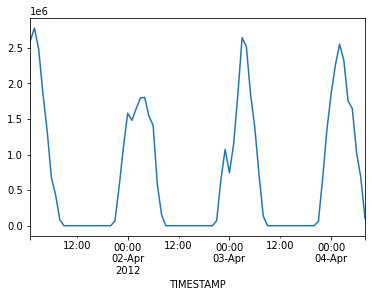

In [5]:
predictor_data['SSRD 2'].iloc[:80].plot()

In [6]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [7]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    #predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()
    #predictor_data[f'TCC*SSRD {i}'] /= predictor_data[f'TCC*SSRD {i}'].max()

In [8]:
predictor_zones = []
train_data_zones = []

for i in range(1, 4):
    predictor = predictor_data[[f'SSRD {i}', f'STRD {i}', f'TSR {i}', f'TP {i}', f'TCC {i}'#, f'TCC*SSRD {i}'
    ]]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {i}']]
    train_data_zones.append(train_data_zone)

In [9]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [10]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [11]:
from tqdm import tqdm

yq_output_zones = []

for x_input, y_output in tqdm(zip(x_input_zones, y_output_zones)):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

3it [00:57, 19.17s/it]


# Train the linear regression model (ANN6)

In [12]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index().drop('TIMESTAMP', axis=1)
      #.rename(columns={
      #  f'SSRD {zoneid}': 0,
      #  f'STRD {zoneid}': 1,
      #  f'TSR {zoneid}': 2, 
      #  f'TP {zoneid}': 3,
        #f'TCC*SSRD {zoneid}': 4
      #  })
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,SSRD 1,STRD 1,TSR 1,TP 1,TCC 1
0,0.635857,0.749657,0.673847,0.000000,0.244601
1,0.685296,0.775649,0.727011,0.000000,0.457138
2,0.632863,0.769635,0.703986,0.001341,0.771429
3,0.478215,0.773120,0.563346,0.002501,0.965866
4,0.316365,0.830914,0.417683,0.003331,0.944669
...,...,...,...,...,...
12427,0.000000,0.554566,0.000000,0.000000,0.002655
12428,0.012648,0.555094,0.021965,0.000000,0.000000
12429,0.154729,0.591132,0.180680,0.000000,0.000000
12430,0.334099,0.604797,0.357403,0.000000,0.000000


## Prepare data for regression model

In [13]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)\
            .rename(columns=lambda name: f't-{h1 - i - 1}: {name}')
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x_zones.append(x)

x_zones[0]

,t-0: SSRD 1,t-0: STRD 1,t-0: TSR 1,t-0: TP 1,t-0: TCC 1,t-1: SSRD 1,t-1: STRD 1,t-1: TSR 1,t-1: TP 1,t-1: TCC 1,...,t-22: SSRD 1,t-22: STRD 1,t-22: TSR 1,t-22: TP 1,t-22: TCC 1,t-23: SSRD 1,t-23: STRD 1,t-23: TSR 1,t-23: TP 1,t-23: TCC 1
23,0.369822,0.854196,0.442339,0.006801,0.932465,0.251112,0.788924,0.314938,0.006791,0.953293,...,0.685296,0.775649,0.727011,0.000000,0.457138,0.635857,0.749657,0.673847,0.000000,0.244601
24,0.423729,0.818798,0.513562,0.000191,0.830276,0.369822,0.854196,0.442339,0.006801,0.932465,...,0.632863,0.769635,0.703986,0.001341,0.771429,0.685296,0.775649,0.727011,0.000000,0.457138
25,0.396691,0.839785,0.504277,0.000263,0.685303,0.423729,0.818798,0.513562,0.000191,0.830276,...,0.478215,0.773120,0.563346,0.002501,0.965866,0.632863,0.769635,0.703986,0.001341,0.771429
26,0.444420,0.860700,0.536485,0.000285,0.768799,0.396691,0.839785,0.504277,0.000263,0.685303,...,0.316365,0.830914,0.417683,0.003331,0.944669,0.478215,0.773120,0.563346,0.002501,0.965866
27,0.445557,0.840864,0.529245,0.000297,0.538910,0.444420,0.860700,0.536485,0.000285,0.768799,...,0.165923,0.812934,0.257348,0.003960,0.641353,0.316365,0.830914,0.417683,0.003331,0.944669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12427,0.000000,0.554566,0.000000,0.000000,0.002655,0.000000,0.560989,0.000000,0.000000,0.226990,...,0.120425,0.657392,0.152408,0.000000,0.829559,0.010009,0.626760,0.017679,0.000000,0.895538
12428,0.012648,0.555094,0.021965,0.000000,0.000000,0.000000,0.554566,0.000000,0.000000,0.002655,...,0.293342,0.654130,0.333632,0.000000,0.498962,0.120425,0.657392,0.152408,0.000000,0.829559
12429,0.154729,0.591132,0.180680,0.000000,0.000000,0.012648,0.555094,0.021965,0.000000,0.000000,...,0.443030,0.653542,0.483290,0.000000,0.250092,0.293342,0.654130,0.333632,0.000000,0.498962
12430,0.334099,0.604797,0.357403,0.000000,0.000000,0.154729,0.591132,0.180680,0.000000,0.000000,...,0.582086,0.655863,0.603266,0.000000,0.049347,0.443030,0.653542,0.483290,0.000000,0.250092


## Feature selection

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=50).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, x.columns[support]]
    x_new_zones.append(x_new)

(11688, 120)
(11688,)
[  0   1   2   5   6   7  10  12  15  17  30  32  35  37  40  42  45  47
  50  52  55  57  60  62  65  67  69  70  72  74  75  77  79  80  82  84
  89  95  97 100 102 105 107 108 110 112 113 115 117 118]
(11688, 120)
(11688,)
[  0   1   2   5   7  10  12  15  17  30  32  35  37  40  42  45  47  50
  52  55  57  60  62  65  67  70  72  74  75  77  79  80  82  84  89  95
  97  98 100 102 103 105 107 108 110 112 113 115 117 118]
(11688, 120)
(11688,)
[  0   2   5   7  10  12  15  17  30  32  35  37  40  42  45  47  50  52
  55  57  60  62  65  67  70  72  74  75  77  79  80  82  84  89  95  97
  98 100 102 103 105 107 108 110 112 113 115 117 118 119]


In [15]:
# x_normalized = (x_new - x_new.mean()) / x_new.std()
# x_normalized

# Training

In [16]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

# todo
# ensemble_size = 7
ensemble_size = 1

predictions_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    predictions = [pd.DataFrame() for _ in range(ensemble_size)]

    for p in tqdm(range(1, 100)):
        for prediction in predictions:
            y_train = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
            x_train = x_new[:-gefcom14_metadata['prediction_length']]
            x_predict = x_new[-gefcom14_metadata['prediction_length']:]

            model = MLPRegressor(hidden_layer_sizes=(20,10,))

            trained = model.fit(x_train, y_train)
            prediction.insert(p-1, str(p/100), trained.predict(x_predict))
    predictions_zones.append(predictions)

100%|██████████| 99/99 [00:55<00:00,  1.79it/s]


In [17]:
predictions_zones[0][0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.056494,0.040925,0.084243,0.083746,0.110369,0.117939,0.106952,0.113196,0.129143,0.163535,...,0.654412,0.649613,0.679743,0.658228,0.687528,0.711076,0.724198,0.708012,0.732565,0.742783
1,0.133430,0.157806,0.159379,0.195599,0.190280,0.222359,0.234556,0.287110,0.264428,0.283727,...,0.763852,0.721256,0.739080,0.736438,0.746461,0.807399,0.786336,0.776823,0.806670,0.789898
2,0.171166,0.230843,0.222750,0.262601,0.250819,0.284694,0.323004,0.394380,0.373280,0.351532,...,0.790861,0.766527,0.765960,0.803167,0.780049,0.791893,0.819679,0.805363,0.808075,0.822570
3,0.156956,0.222755,0.196338,0.230116,0.231699,0.265585,0.315646,0.348508,0.349821,0.297970,...,0.791127,0.761065,0.775527,0.784543,0.782626,0.792758,0.798909,0.794381,0.793767,0.826218
4,0.101766,0.136745,0.137261,0.132679,0.149560,0.187116,0.202925,0.229608,0.226846,0.218034,...,0.732222,0.723835,0.725428,0.715811,0.747464,0.739117,0.754603,0.747779,0.744067,0.787987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.006452,0.002416,0.017913,0.000804,0.020662,0.006724,0.007388,0.005046,-0.005738,0.010914,...,-0.042255,-0.030962,0.010492,0.012056,-0.007022,0.024619,-0.004760,-0.013473,0.000310,0.008800
740,0.001014,-0.003154,-0.009464,-0.001093,-0.001211,-0.000111,0.013500,0.007656,0.005471,-0.000399,...,0.002743,-0.002451,0.049117,0.011625,-0.011553,0.071765,0.017636,0.014538,0.000493,0.023130
741,0.021947,0.014601,0.015187,0.025961,0.017269,0.033851,0.037366,0.021323,0.022234,0.031389,...,0.275458,0.289204,0.328593,0.325039,0.331199,0.373807,0.357954,0.362593,0.420404,0.465632
742,0.056248,0.055429,0.080856,0.075905,0.098466,0.076191,0.076885,0.079309,0.103072,0.124642,...,0.624277,0.641817,0.633200,0.683881,0.667495,0.631493,0.724515,0.687264,0.707986,0.763867


# Postprocessing: Remove quantile crossing

In [18]:
averaged_predictions_zones = []

for predictions in predictions_zones:
    # ensemble averaging
    averaged_predictions = pd.DataFrame()

    for p in range(1, 100):
        quantile_columns = [prediction[str(p/100)] for prediction in predictions]
        averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))

    averaged_predictions.insert(0, 'TIMESTAMP', predictions[0].index)
    averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

    averaged_predictions_zones.append(averaged_predictions)

In [19]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(averaged_predictions_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [20]:
#!mkdir -p results

In [21]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
0,1,0.040925,0.056494,0.083746,0.084243,0.106952,0.110369,0.113196,0.117939,0.129143,...,0.649613,0.654412,0.658228,0.679743,0.687528,0.708012,0.711076,0.724198,0.732565,0.742783
1,1,0.133430,0.157806,0.159379,0.190280,0.195599,0.222359,0.234556,0.264428,0.283727,...,0.736438,0.737274,0.739080,0.746461,0.763852,0.776823,0.786336,0.789898,0.806670,0.807399
2,1,0.171166,0.222750,0.230843,0.250819,0.262601,0.284694,0.323004,0.351532,0.373280,...,0.780130,0.780729,0.790861,0.791893,0.794405,0.803167,0.805363,0.808075,0.819679,0.822570
3,1,0.156956,0.196338,0.222755,0.230116,0.231699,0.265585,0.297970,0.315646,0.348508,...,0.775527,0.780022,0.782626,0.784543,0.791127,0.792758,0.793767,0.794381,0.798909,0.826218
4,1,0.101766,0.132679,0.136745,0.137261,0.149560,0.187116,0.202925,0.218034,0.226846,...,0.723835,0.725428,0.732222,0.732566,0.739117,0.744067,0.747464,0.747779,0.754603,0.787987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.040129,0.040519,0.045806,0.056927,0.058878,0.061684,0.067645,0.081609,0.090389,0.136035
740,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.067801,0.069965,0.090753,0.094344,0.096219,0.118261,0.127507,0.140246,0.154441,0.171436
741,3,0.000000,0.008137,0.008876,0.018351,0.025361,0.029161,0.030191,0.033633,0.034676,...,0.357050,0.361832,0.372223,0.380806,0.427410,0.442498,0.445870,0.448592,0.518539,0.530349


# Plotting the quantile prediction for the first entries

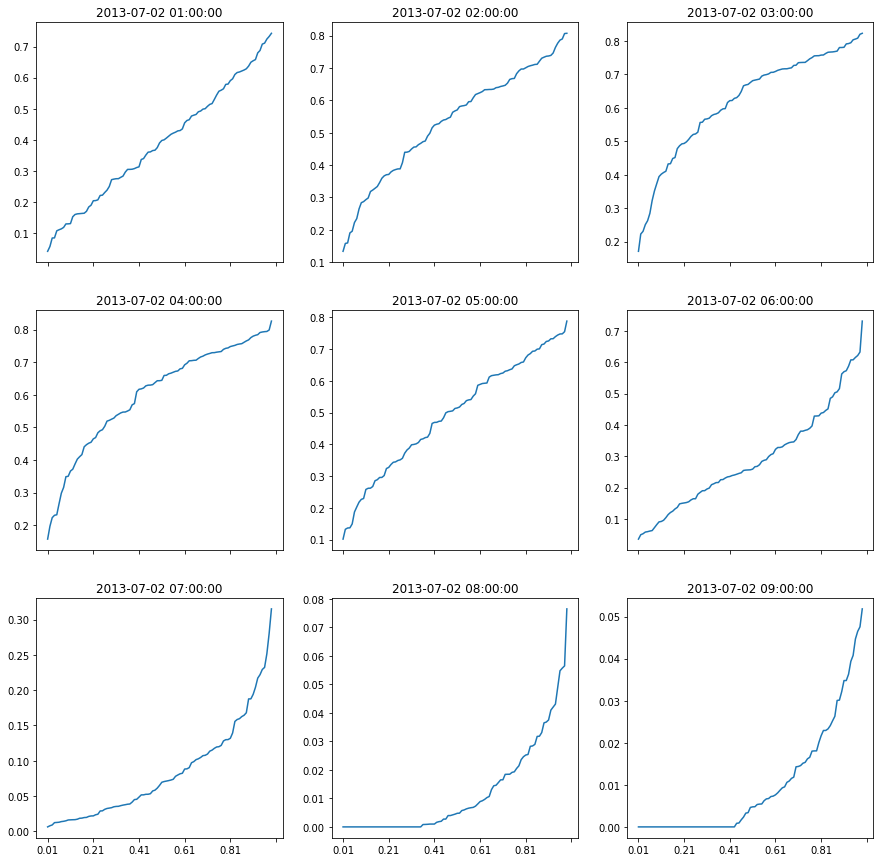

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [23]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

##%%

test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[1][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[2][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 5 with NNQF: 0.02185


In [24]:
loss1

0.01993242336216076